🔹 1.1 Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set(style="whitegrid")

pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: f"{x:.2f}")

🔹 1.2 Define Paths

In [2]:
BASE_PATH = Path("../data")
RAW_PATH = BASE_PATH / "raw"
PROCESSED_PATH = BASE_PATH / "processed"

print("Raw path:", RAW_PATH)
print("Processed path:", PROCESSED_PATH)

Raw path: ..\data\raw
Processed path: ..\data\processed


🔹 1.3 Load Data

In [16]:
main_df = pd.read_csv(PROCESSED_PATH / "ethiopia_fi_enriched_data.csv")
impact_df = pd.read_csv(PROCESSED_PATH / "ethiopia_fi_enriched_impact_links.csv")

print("Main data shape:", main_df.shape)
print("Impact links shape:", impact_df.shape)

main_df.head()

Main data shape: (56, 36)
Impact links shape: (21, 35)


,record_id,record_type,category,pillar,indicator,indicator_code,indicator_direction,value_numeric,value_text,value_type,unit,observation_date,period_start,period_end,fiscal_year,gender,location,region,source_name,source_type,source_url,confidence,related_indicator,relationship_type,impact_direction,impact_magnitude,impact_estimate,lag_months,evidence_basis,comparable_country,collected_by,collection_date,original_text,notes,event_name,event_date
0,REC_0001,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,22.00,NaN,percentage,%,2014-12-31,NaN,NaN,2014,all,national,NaN,Global Findex 2014,survey,https://www.worldbank.org/en/publication/globa...,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20 00:00:00,NaN,Baseline year,NaN,NaN,NaN
1,REC_0002,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,35.00,NaN,percentage,%,2017-12-31,NaN,NaN,2017,all,national,NaN,Global Findex 2017,survey,https://www.worldbank.org/en/publication/globa...,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20 00:00:00,NaN,NaN,NaN,NaN,NaN
2,REC_0003,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,46.00,NaN,percentage,%,2021-12-31,NaN,NaN,2021,all,national,NaN,Global Findex 2021,survey,https://www.worldbank.org/en/publication/globa...,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20 00:00:00,NaN,NaN,NaN,NaN,NaN
3,REC_0004,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,56.00,NaN,percentage,%,2021-12-31,NaN,NaN,2021,male,national,NaN,Global Findex 2021,survey,https://www.worldbank.org/en/publication/globa...,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20 00:00:00,NaN,Gender disaggregated,NaN,NaN,NaN
4,REC_0005,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,36.00,NaN,percentage,%,2021-12-31,NaN,NaN,2021,female,national,NaN,Global Findex 2021,survey,https://www.worldbank.org/en/publication/globa...,high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Example_Trainee,2025-01-20 00:00:00,NaN,Gender disaggregated,NaN,NaN,NaN


🔷 2. Exploratory Data Overview

🔹 2.1 Record Counts

In [4]:
main_df["record_type"].value_counts()

record_type
observation    38
event          15
target          3
Name: count, dtype: int64

In [5]:
main_df["pillar"].value_counts()

pillar
ACCESS            21
USAGE             13
GENDER             5
AFFORDABILITY      1
Infrastructure     1
Name: count, dtype: int64

In [6]:
main_df["source_type"].value_counts()

source_type
operator      15
survey        10
regulator      7
research       4
policy         3
calculated     2
news           2
Name: count, dtype: int64

In [7]:
main_df["confidence"].value_counts()

confidence
high      40
High      13
medium     3
Name: count, dtype: int64

🔹 2.2 Temporal Coverage

In [8]:
import pandas as pd
from pathlib import Path

PROCESSED_PATH = Path("../data/processed")  
main_df = pd.read_csv(PROCESSED_PATH / "ethiopia_fi_enriched_data.csv")

# Convert observation_date to datetime and extract year
main_df['observation_date'] = pd.to_datetime(main_df['observation_date'], errors='coerce')
main_df['year'] = main_df['observation_date'].dt.year

main_df.head()

year_coverage = (
    main_df.groupby("indicator_code")["year"]
    .agg(["min", "max", "count"])
    .sort_values("min")
)

year_coverage.head()

,min,max,count
indicator_code,,,
ACC_OWNERSHIP,2014.00,2025.00,7
ACC_MM_ACCOUNT,2021.00,2024.00,2
EVT_TELEBIRR,2021.00,2021.00,1
EVT_NFIS2,2021.00,2021.00,1
GEN_GAP_ACC,2021.00,2024.00,2


Detect missing years:

In [9]:
# Convert fiscal_year to numeric, ignore errors
main_df['year'] = pd.to_numeric(main_df['fiscal_year'], errors='coerce')

# Drop NaNs
year_series = main_df['year'].dropna()

# Convert min and max to integers
year_min = int(year_series.min())
year_max = int(year_series.max())

# Define full range of years
all_years = set(range(year_min, year_max + 1))

# Function to detect missing years per indicator
def missing_years(x):
    return sorted(list(all_years - set(x)))

# Apply per indicator
missing_years_df = (
    main_df.groupby('indicator_code')['year']
    .apply(missing_years)
    .reset_index(name='missing_years')
)

missing_years_df.head()

,indicator_code,missing_years
0,ACC_4G_COV,"[2014, 2015, 2016, 2017, 2018, 2019, 2020, 202..."
1,ACC_AGENT,"[2014, 2015, 2016, 2017, 2018, 2019, 2020, 202..."
2,ACC_ATM,"[2014, 2015, 2016, 2017, 2018, 2019, 2020, 202..."
3,ACC_DIGID,"[2014, 2015, 2016, 2017, 2018, 2019, 2020, 202..."
4,ACC_FAYDA,"[2014, 2015, 2016, 2017, 2018, 2019, 2020, 202..."


🔹 2.3 Identify Gaps in Disaggregation

Gender Disaggregation

In [10]:
gender_counts = main_df.groupby(['indicator_code', 'gender']).size().unstack(fill_value=0)
print(gender_counts)

gender              all  female  male
indicator_code                       
ACC_4G_COV            2       0     0
ACC_FAYDA             4       0     0
ACC_MM_ACCOUNT        2       0     0
ACC_MOBILE_PEN        1       0     0
ACC_OWNERSHIP         5       1     1
AFF_DATA_INCOME       1       0     0
EVT_CROSSOVER         1       0     0
EVT_ETHIOPAY          1       0     0
EVT_FAYDA             1       0     0
EVT_FX_REFORM         1       0     0
EVT_MPESA             1       0     0
EVT_MPESA_INTEROP     1       0     0
EVT_NFIS2             1       0     0
EVT_SAFARICOM         1       0     0
EVT_SAFCOM_PRICE      1       0     0
EVT_TELEBIRR          1       0     0
GEN_GAP_ACC           2       0     0
GEN_GAP_MOBILE        1       0     0
GEN_MM_SHARE          0       2     0
USG_ACTIVE_RATE       1       0     0
USG_ATM_COUNT         1       0     0
USG_ATM_VALUE         1       0     0
USG_CROSSOVER         1       0     0
USG_MPESA_ACTIVE      1       0     0
USG_MPESA_US

Regional/Location Disaggregation

In [11]:
region_counts = main_df.groupby(['indicator_code', 'region']).size().unstack(fill_value=0)
print(region_counts)

Empty DataFrame
Columns: []
Index: []


consolidated data gaps table

In [30]:
import pandas as pd

# Ensure 'year' column exists
main_df['year'] = pd.to_numeric(main_df['fiscal_year'], errors='coerce')

# 🔹 1. Detect missing years per indicator
all_years = set(range(int(main_df['year'].min()), int(main_df['year'].max()) + 1))

def missing_years(x):
    return sorted(list(all_years - set(x)))

missing_years_df = main_df.groupby("indicator_code")["year"].apply(missing_years).reset_index(name="missing_years")

# 🔹 2. Detect missing gender disaggregation
gender_counts = main_df.groupby(['indicator_code', 'gender']).size().unstack(fill_value=0)

# Assuming 'all' column exists for total
gender_counts['missing_female'] = gender_counts.apply(lambda row: 1 if 'female' not in row or row['female'] == 0 else 0, axis=1)
gender_counts['missing_male']   = gender_counts.apply(lambda row: 1 if 'male' not in row or row['male'] == 0 else 0, axis=1)

# 🔹 3. Detect missing regional disaggregation
region_counts = main_df.groupby(['indicator_code', 'region']).size().unstack(fill_value=0)
region_counts['missing_region'] = region_counts.apply(lambda row: 1 if row.sum() == 0 else 0, axis=1)

# 🔹 4. Merge all gaps into a single table
gaps_df = missing_years_df.merge(
    gender_counts[['missing_female', 'missing_male']], 
    left_on='indicator_code', right_index=True, how='left'
).merge(
    region_counts[['missing_region']], 
    left_on='indicator_code', right_index=True, how='left'
)

# Fill NaNs (in case some indicators don't have gender or region info)
gaps_df[['missing_female','missing_male','missing_region']] = gaps_df[['missing_female','missing_male','missing_region']].fillna(1).astype(int)

# 🔹 5. Sort by number of missing years (optional)
gaps_df['n_missing_years'] = gaps_df['missing_years'].apply(len)
gaps_df = gaps_df.sort_values(by='n_missing_years', ascending=False)

# Preview
gaps_df.head(20)

,indicator_code,missing_years,missing_female,missing_male,missing_region,n_missing_years
0,ACC_4G_COV,"[2014, 2015, 2016, 2017, 2018, 2019, 2020, 202...",1,1,1,17
1,ACC_AGENT,"[2014, 2015, 2016, 2017, 2018, 2019, 2020, 202...",1,1,1,17
2,ACC_ATM,"[2014, 2015, 2016, 2017, 2018, 2019, 2020, 202...",1,1,1,17
3,ACC_DIGID,"[2014, 2015, 2016, 2017, 2018, 2019, 2020, 202...",1,1,1,17
5,ACC_GENDER,"[2014, 2015, 2016, 2017, 2018, 2019, 2020, 202...",1,1,1,17
9,ACC_URBAN_RURAL,"[2014, 2015, 2016, 2017, 2018, 2019, 2020, 202...",1,1,1,17
11,EVT_CROSSOVER,"[2014, 2015, 2016, 2017, 2018, 2019, 2020, 202...",1,1,1,17
12,EVT_ETHIOPAY,"[2014, 2015, 2016, 2017, 2018, 2019, 2020, 202...",1,1,1,17
16,EVT_MPESA_INTEROP,"[2014, 2015, 2016, 2017, 2018, 2019, 2020, 202...",1,1,1,17
25,USG_ATM_COUNT,"[2014, 2015, 2016, 2017, 2018, 2019, 2020, 202...",1,1,1,17


Data Gap Heatmap

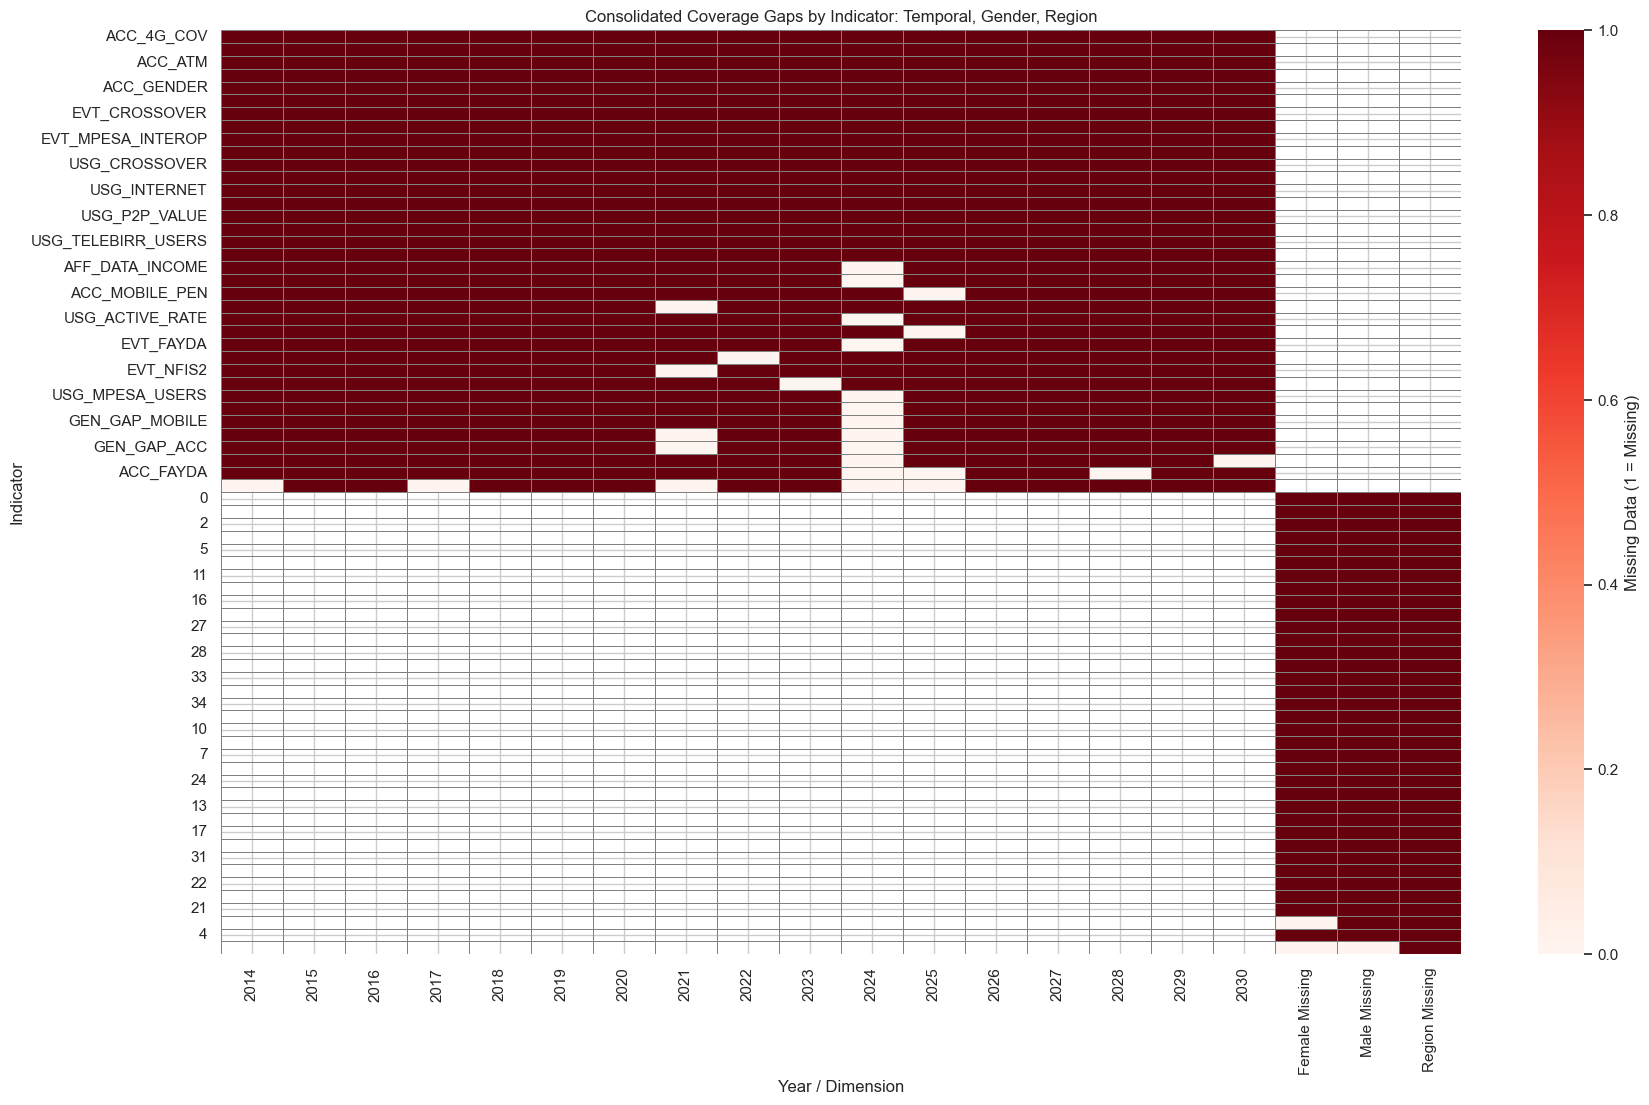

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Prepare temporal coverage
years = sorted(set(range(int(main_df['year'].min()), int(main_df['year'].max()) + 1)))
temporal_matrix = pd.DataFrame(0, index=gaps_df['indicator_code'], columns=[str(y) for y in years])

for i, row in gaps_df.iterrows():
    for y in row['missing_years']:
        temporal_matrix.at[row['indicator_code'], str(y)] = 1  # 1 = missing

# 2️⃣ Add gender and region gaps as additional columns
gender_region_matrix = gaps_df[['missing_female', 'missing_male', 'missing_region']].copy()
gender_region_matrix = gender_region_matrix.rename(columns={
    'missing_female': 'Female Missing', 
    'missing_male': 'Male Missing',
    'missing_region': 'Region Missing'
})

# 3️⃣ Combine temporal + gender/region
consolidated_matrix = pd.concat([temporal_matrix, gender_region_matrix], axis=1)

# 4️⃣ Plot heatmap
plt.figure(figsize=(20, 12))
sns.heatmap(consolidated_matrix, cmap="Reds", cbar_kws={'label': 'Missing Data (1 = Missing)'}, linewidths=0.5, linecolor='gray')
plt.title("Consolidated Coverage Gaps by Indicator: Temporal, Gender, Region")
plt.xlabel("Year / Dimension")
plt.ylabel("Indicator")
plt.show()

🔹 3. Prioritization Against Success Metrics

In [39]:
# Step 0: Make missing_data from gaps_df
missing_data = gaps_df.copy()

# Optional: create a priority column if not yet created
def assign_priority(row):
    if len(row['missing_years']) > 10 or row['missing_female'] > 0 or row['missing_male'] > 0 or row['missing_region'] > 0:
        return 'High'
    elif len(row['missing_years']) > 5:
        return 'Medium'
    else:
        return 'Low'

missing_data['priority'] = missing_data.apply(assign_priority, axis=1)

# Map priority to numeric values
priority_map = {'High': 3, 'Medium': 2, 'Low': 1}
missing_data['priority_num'] = missing_data['priority'].map(priority_map)

In [40]:
metric_map = {
    'ACC_OWNERSHIP': 'Account Ownership',
    'ACC_MM_ACCOUNT': 'Account Ownership',
    'ACC_4G_COV': 'Account Ownership',
    'USG_ACTIVE_RATE': 'Digital Payment Usage',
    'USG_TELEBIRR_USERS': 'Digital Payment Usage',
    'USG_MM_USERS': 'Digital Payment Usage',
    'USG_P2P_VALUE': 'Digital Payment Usage',
    'EVT_TELEBIRR': 'Event Impact',
    'EVT_MPESA': 'Event Impact',
    'EVT_CROSSOVER': 'Event Impact',
    'EVT_FX_REFORM': 'Event Impact',
    'EVT_ETHIOPAY': 'Event Impact'
}

missing_data['success_metric'] = missing_data['indicator_code'].map(metric_map).fillna('Other')

# Compute combined score
missing_data['combined_score'] = missing_data.apply(
    lambda x: x['priority_num']*2 if x['success_metric'] != 'Other' else x['priority_num'], axis=1
)

# Sort by priority
priority_list = missing_data.sort_values('combined_score', ascending=False)
priority_list[['indicator_code','success_metric','priority','combined_score']]


,indicator_code,success_metric,priority,combined_score
0,ACC_4G_COV,Account Ownership,High,6
33,USG_P2P_VALUE,Digital Payment Usage,High,6
11,EVT_CROSSOVER,Event Impact,High,6
12,EVT_ETHIOPAY,Event Impact,High,6
6,ACC_MM_ACCOUNT,Account Ownership,High,6
15,EVT_MPESA,Event Impact,High,6
8,ACC_OWNERSHIP,Account Ownership,High,6
29,USG_MM_USERS,Digital Payment Usage,High,6
34,USG_TELEBIRR_USERS,Digital Payment Usage,High,6
14,EVT_FX_REFORM,Event Impact,High,6


In [42]:
# Map indicators to success metric category
metric_map = {
    'ACC_OWNERSHIP': 'Account Ownership',
    'ACC_MM_ACCOUNT': 'Account Ownership',
    'ACC_4G_COV': 'Account Ownership',
    'USG_ACTIVE_RATE': 'Digital Payment Usage',
    'USG_TELEBIRR_USERS': 'Digital Payment Usage',
    'USG_MM_USERS': 'Digital Payment Usage',
    'USG_P2P_VALUE': 'Digital Payment Usage',
    'EVT_TELEBIRR': 'Event Impact',
    'EVT_MPESA': 'Event Impact',
    'EVT_CROSSOVER': 'Event Impact',
    'EVT_FX_REFORM': 'Event Impact',
    'EVT_ETHIOPAY': 'Event Impact'
}

missing_data['success_metric'] = missing_data['indicator_code'].map(metric_map).fillna('Other')

# Compute a combined score: priority_num * weight (weight 2 for key success metrics, 1 otherwise)
missing_data['combined_score'] = missing_data.apply(
    lambda x: x['priority_num']*2 if x['success_metric'] != 'Other' else x['priority_num'], axis=1
)

# Sort descending to get top indicators to tackle first
priority_list = missing_data.sort_values('combined_score', ascending=False)
priority_list[['indicator_code','success_metric','priority','combined_score']]


,indicator_code,success_metric,priority,combined_score
0,ACC_4G_COV,Account Ownership,High,6
33,USG_P2P_VALUE,Digital Payment Usage,High,6
11,EVT_CROSSOVER,Event Impact,High,6
12,EVT_ETHIOPAY,Event Impact,High,6
6,ACC_MM_ACCOUNT,Account Ownership,High,6
15,EVT_MPESA,Event Impact,High,6
8,ACC_OWNERSHIP,Account Ownership,High,6
29,USG_MM_USERS,Digital Payment Usage,High,6
34,USG_TELEBIRR_USERS,Digital Payment Usage,High,6
14,EVT_FX_REFORM,Event Impact,High,6


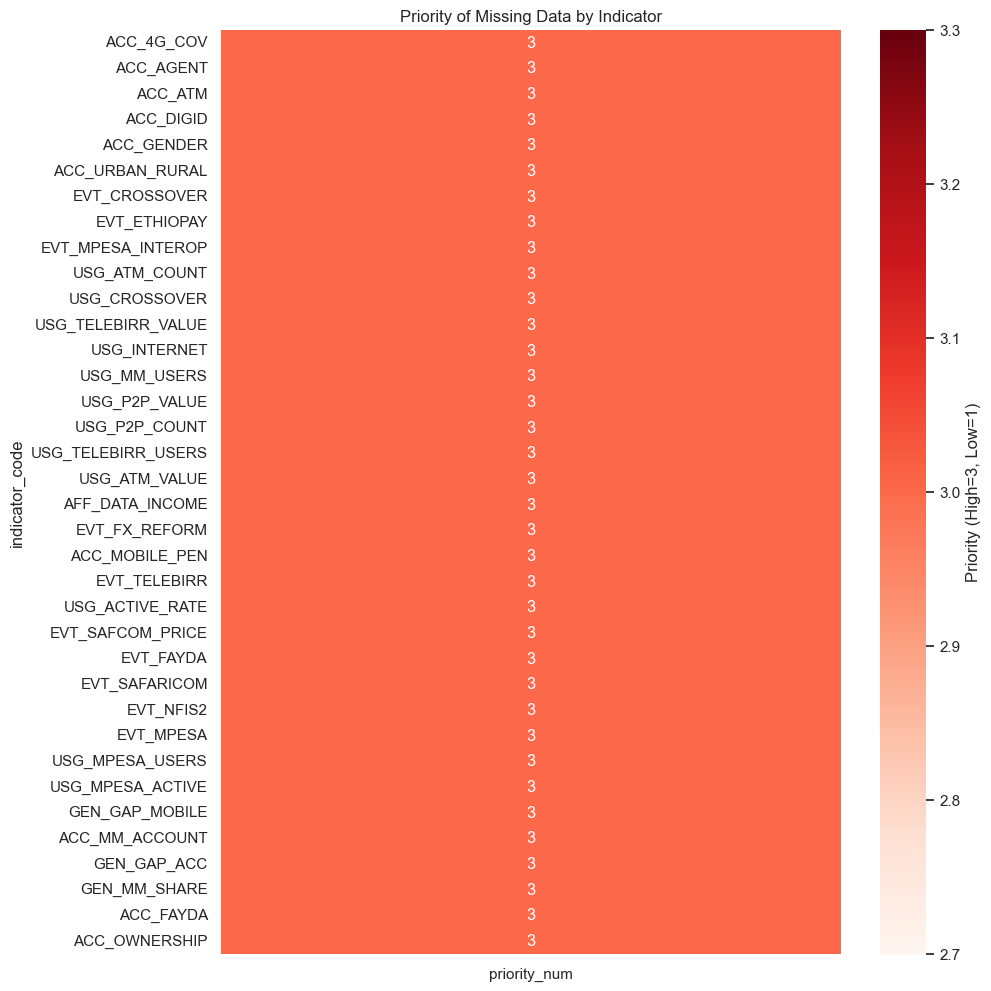

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

heatmap_data = missing_data.set_index('indicator_code')[['priority_num']]
plt.figure(figsize=(10,12))
sns.heatmap(heatmap_data, annot=True, cmap='Reds', cbar_kws={'label':'Priority (High=3, Low=1)'})
plt.title("Priority of Missing Data by Indicator")
plt.show()


🔹 4. Data collection Against Success Metrics- Prioritised data's

In [27]:
import pandas as pd
from pathlib import Path

# Define path
raw_path = Path(r"D:\Personal\KAIM-10 Academy\week 10\Project\ethiopia-fi-forecast\data\raw")

# Load Findex dataset
findex_df = pd.read_csv(raw_path / "GlobalFindexDatabase2025.csv")

print("Shape:", findex_df.shape)
findex_df.head()


C:\Users\user\AppData\Local\Temp\ipykernel_18784\1403581794.py:8: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  findex_df = pd.read_csv(raw_path / "GlobalFindexDatabase2025.csv")


Shape: (8564, 437)


,countrynewwb,codewb,year,pop_adult,regionwb24_hi,incomegroupwb24,group,group2,account_t_d,fiaccount_t_d,mobileaccount_t_d,borrow_any_t_d,fin4_d,dig_acc,fin11_2a,fin11a,fin11b,fin11c,fin11f,fin11d,fin11e,fin14a,fin14b,fin14c,fin14d,fin13_1a,fin13_1b,fin26a,fin26b,fin27a,fin27b,fin17f,fin17a_17a1_d,fin17a,fin17b,fin17c,fin22d,fin22e,fin22a_22a1_22g_d,fin22a,fin22a_1,fin22b,fin22c,fin24sav,fin24fam,fin24work,fin24bor,fin24sell,fin24other,fin24aVD,fin24aSD,fin24aND,fin24aSD_ND,fin24aP,fin24aN,fin24sav_SD_ND,fin24fam_SD_ND,fin24work_SD_ND,fin24bor_SD_ND,fin24sell_SD_ND,fin24other_SD_ND,fin24sav_VD,fin24fam_VD,fin24work_VD,fin24bor_VD,fin24sell_VD,fin24other_VD,fh1,fin28,fh2,fin29,fin31a_31b,fin30,fin31a,fin31b,fin31d,fin32_33_34a,fin32_33_34b,fin32_33_34c,fin32_33_34d,fin32_33_acc,fin32_33,fin32_n33_34a,fin32_n33_34b,fin32_n33_34c,fin32_n33_34d,fin32_n33_acc,fin32_n33,fin32,fin32_acc,fin34a,fin34b,fin34c,fin34d,fin37_38_39a,fin37_38_39b,fin37_38_39c,fin37_38_39d,fin37_38_39_acc,fin37_38,fin37_39a,fin37_39b,fin37_39c,fin37_39d,fin37_39_acc,fin37,fin38_39a,fin38_39b,fin38_39c,fin38_39d,fin38_39_acc,fin38,fin2_t_d,fin42,fin42_acc,fin43a,fin43b,fin43c,fin43d,fin45a,fin45c,fin45d,fin45e,fin45b,fin25e2,fin9b,fin10,fin22g,fin22h,inactive_t_d,fing2p_acc,fing2p_card,fing2p_cash,fing2p_fin,fing2p_mob,fing2p,g20_made,g20_received,g20_any,merchant_pay,save_any_t_d,fin11_1,fin5w,fin5m,fin5lm,fin5n,fin6w,fin6m,fin6lm,fin6n,fin11_0,fin9a,fin17dw,fin17dm,fin17dlm,fin17e,fin7,fin3,fin19,fin20,fin21,fin24ba,fin24bb,fin24bc,fin24bd,fin24c,fin24d1,fin24d2,fin24d3,fin25e1,fin25e2b,fin25e3w,fin25e3m,fin25e3lm,fin25e4a,fin25e4b,fin25e4c,fin25e4d,fin25e4e,fh2a,fin31c,fin36a,fin36b,fin40a,fin40b,fin36Aa,fin36Ab,fin8,fin13aw,fin13am,fin13alm,fin13an,fin13bw,fin13bm,fin13blm,fin13bn,fin13cw,fin13cm,fin13clm,fin13cn,fin13e,fin13f,fin13f_1,fin15,fin16,fin22f,fin41,fin35,fin44,fh1_fh2,fin28_29,fin31d_s,fin32_n33_34c_s,fin34c_s,fin43c_s,fin32_acc_s,fin34a_s,fin32_33_acc_s,inactive_t_d_s,fing2p_fin_s,fin32_33_34a_s,fin32_n33_acc_s,fin37_39_acc_s,fin37_39c_s,fin31a_31b_s,fin31a_s,fin31b_s,fin32_n33_34a_s,fin37_39a_s,fin34d_s,fin32_33_34d_s,fin32_n33_34d_s,fing2p_card_s,fin37_39d_s,fin42_acc_s,fin32_33_34c_s,fin37_38_39c_s,fin38_39c_s,fing2p_acc_s,fing2p_cash_s,fin37_38_39a_s,fin37_38_39_acc_s,fin38_39a_s,fin38_39_acc_s,fin34b_s,fin32_n33_34b_s,fin43b_s,fin27b_s,fin27a_s,fin22h_s,fin28_29_s,fin28_s,fin29_s,fing2p_mob_s,fin37_38_39d_s,fin37_38_39b_s,fin37_39b_s,fin11_2a_s,fin11b_s,fin11f_s,fin11d_s,fin11e_s,fin9b_s,fin11_1_s,fin5m_s,fin6m_s,fin9a_s,fin5w_s,fin6w_s,fin17dm_s,fin17dlm_s,fin25e3w_s,fin25e3m_s,fin24d1_s,fin14d_s,fin24d2_s,fin11a_s,fin11c_s,fin5lm_s,fin6lm_s,fin17dw_s,fin14c_s,fin13_1a_s,fin13_1b_s,fin13am_s,fin13alm_s,fin13bm_s,fin13blm_s,fin13cm_s,fin13clm_s,fin21_s,fin14b_s,fin13cw_s,fin13f_s,fin14a_s,fin25e3lm_s,fin13aw_s,fin13bw_s,fin24d3_s,fin5n_s,fin6n_s,fin13f_1_s,fin32_33_34b_s,con1,con2a,con2b,con2c,con2d,con2e,con2f,con2g,con3a,con3b,con3c,con3d,con3e,con3f,con3g,con4,con5a,con5b,con6,con7,con8,con9a,con9b,con10,con11,con12d,con12w,con12m,con12lm,con13,con14,con15,con16,con17a,con17b,con17c,con17d,con18,con19,con20,con21,con22,con23,internet,con26d,con26w,con26m,con26lm,con27,con28d,con28w,con28m,con28lm,con28n,con29,con30a,con30b,con30c,con30d,con30e,con30f,con30g,con30h,con31a,con31b,con31c,con31d,con31e,con31f,con31g,con31h,con32a,con32b,con32c,con32d,con32e,con32f,con32g,con32h,con10_s,con11_s,con12d_s,con14_s,con16_s,con17a_s,con17b_s,con18_s,con19_s,con20_s,con21_s,con26d_s,con27_s,con28m_s,con30a_s,con30b_s,con30c_s,con30d_s,con30e_s,con30f_s,con30g_s,con30h_s,con31a_s,con31b_s,con31f_s,con2a_s,con15_s,con17d_s,con29_s,con31d_s,con31h_s,con32a_s,con3a_s,con4_s,con28d_s,con28w_s,con23_s,con31c_s,con2b_s,con2d_s,con26w_s,con2c_s,con2e_s,con2g_s,con5b_s,con12m_s,con26lm_s,con12w_s,con2f_s,con13_s,con26m_s,con28lm_s,con5a_s,con17c_s,con32h_s
0,Afghanistan,AFG,2011,14575546.00,South Asia (excluding high income),Low income,all,all,0.09,0.09,

In [44]:
# filter Ethiopia ONly 
import pandas as pd

findex_df = pd.read_csv("../data/raw/GlobalFindexDatabase2025.csv")

print(findex_df.shape)
findex_df.head()

C:\Users\user\AppData\Local\Temp\ipykernel_18784\3635269427.py:4: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  findex_df = pd.read_csv("../data/raw/GlobalFindexDatabase2025.csv")


(8564, 437)


,countrynewwb,codewb,year,pop_adult,regionwb24_hi,incomegroupwb24,group,group2,account_t_d,fiaccount_t_d,mobileaccount_t_d,borrow_any_t_d,fin4_d,dig_acc,fin11_2a,fin11a,fin11b,fin11c,fin11f,fin11d,fin11e,fin14a,fin14b,fin14c,fin14d,fin13_1a,fin13_1b,fin26a,fin26b,fin27a,fin27b,fin17f,fin17a_17a1_d,fin17a,fin17b,fin17c,fin22d,fin22e,fin22a_22a1_22g_d,fin22a,fin22a_1,fin22b,fin22c,fin24sav,fin24fam,fin24work,fin24bor,fin24sell,fin24other,fin24aVD,fin24aSD,fin24aND,fin24aSD_ND,fin24aP,fin24aN,fin24sav_SD_ND,fin24fam_SD_ND,fin24work_SD_ND,fin24bor_SD_ND,fin24sell_SD_ND,fin24other_SD_ND,fin24sav_VD,fin24fam_VD,fin24work_VD,fin24bor_VD,fin24sell_VD,fin24other_VD,fh1,fin28,fh2,fin29,fin31a_31b,fin30,fin31a,fin31b,fin31d,fin32_33_34a,fin32_33_34b,fin32_33_34c,fin32_33_34d,fin32_33_acc,fin32_33,fin32_n33_34a,fin32_n33_34b,fin32_n33_34c,fin32_n33_34d,fin32_n33_acc,fin32_n33,fin32,fin32_acc,fin34a,fin34b,fin34c,fin34d,fin37_38_39a,fin37_38_39b,fin37_38_39c,fin37_38_39d,fin37_38_39_acc,fin37_38,fin37_39a,fin37_39b,fin37_39c,fin37_39d,fin37_39_acc,fin37,fin38_39a,fin38_39b,fin38_39c,fin38_39d,fin38_39_acc,fin38,fin2_t_d,fin42,fin42_acc,fin43a,fin43b,fin43c,fin43d,fin45a,fin45c,fin45d,fin45e,fin45b,fin25e2,fin9b,fin10,fin22g,fin22h,inactive_t_d,fing2p_acc,fing2p_card,fing2p_cash,fing2p_fin,fing2p_mob,fing2p,g20_made,g20_received,g20_any,merchant_pay,save_any_t_d,fin11_1,fin5w,fin5m,fin5lm,fin5n,fin6w,fin6m,fin6lm,fin6n,fin11_0,fin9a,fin17dw,fin17dm,fin17dlm,fin17e,fin7,fin3,fin19,fin20,fin21,fin24ba,fin24bb,fin24bc,fin24bd,fin24c,fin24d1,fin24d2,fin24d3,fin25e1,fin25e2b,fin25e3w,fin25e3m,fin25e3lm,fin25e4a,fin25e4b,fin25e4c,fin25e4d,fin25e4e,fh2a,fin31c,fin36a,fin36b,fin40a,fin40b,fin36Aa,fin36Ab,fin8,fin13aw,fin13am,fin13alm,fin13an,fin13bw,fin13bm,fin13blm,fin13bn,fin13cw,fin13cm,fin13clm,fin13cn,fin13e,fin13f,fin13f_1,fin15,fin16,fin22f,fin41,fin35,fin44,fh1_fh2,fin28_29,fin31d_s,fin32_n33_34c_s,fin34c_s,fin43c_s,fin32_acc_s,fin34a_s,fin32_33_acc_s,inactive_t_d_s,fing2p_fin_s,fin32_33_34a_s,fin32_n33_acc_s,fin37_39_acc_s,fin37_39c_s,fin31a_31b_s,fin31a_s,fin31b_s,fin32_n33_34a_s,fin37_39a_s,fin34d_s,fin32_33_34d_s,fin32_n33_34d_s,fing2p_card_s,fin37_39d_s,fin42_acc_s,fin32_33_34c_s,fin37_38_39c_s,fin38_39c_s,fing2p_acc_s,fing2p_cash_s,fin37_38_39a_s,fin37_38_39_acc_s,fin38_39a_s,fin38_39_acc_s,fin34b_s,fin32_n33_34b_s,fin43b_s,fin27b_s,fin27a_s,fin22h_s,fin28_29_s,fin28_s,fin29_s,fing2p_mob_s,fin37_38_39d_s,fin37_38_39b_s,fin37_39b_s,fin11_2a_s,fin11b_s,fin11f_s,fin11d_s,fin11e_s,fin9b_s,fin11_1_s,fin5m_s,fin6m_s,fin9a_s,fin5w_s,fin6w_s,fin17dm_s,fin17dlm_s,fin25e3w_s,fin25e3m_s,fin24d1_s,fin14d_s,fin24d2_s,fin11a_s,fin11c_s,fin5lm_s,fin6lm_s,fin17dw_s,fin14c_s,fin13_1a_s,fin13_1b_s,fin13am_s,fin13alm_s,fin13bm_s,fin13blm_s,fin13cm_s,fin13clm_s,fin21_s,fin14b_s,fin13cw_s,fin13f_s,fin14a_s,fin25e3lm_s,fin13aw_s,fin13bw_s,fin24d3_s,fin5n_s,fin6n_s,fin13f_1_s,fin32_33_34b_s,con1,con2a,con2b,con2c,con2d,con2e,con2f,con2g,con3a,con3b,con3c,con3d,con3e,con3f,con3g,con4,con5a,con5b,con6,con7,con8,con9a,con9b,con10,con11,con12d,con12w,con12m,con12lm,con13,con14,con15,con16,con17a,con17b,con17c,con17d,con18,con19,con20,con21,con22,con23,internet,con26d,con26w,con26m,con26lm,con27,con28d,con28w,con28m,con28lm,con28n,con29,con30a,con30b,con30c,con30d,con30e,con30f,con30g,con30h,con31a,con31b,con31c,con31d,con31e,con31f,con31g,con31h,con32a,con32b,con32c,con32d,con32e,con32f,con32g,con32h,con10_s,con11_s,con12d_s,con14_s,con16_s,con17a_s,con17b_s,con18_s,con19_s,con20_s,con21_s,con26d_s,con27_s,con28m_s,con30a_s,con30b_s,con30c_s,con30d_s,con30e_s,con30f_s,con30g_s,con30h_s,con31a_s,con31b_s,con31f_s,con2a_s,con15_s,con17d_s,con29_s,con31d_s,con31h_s,con32a_s,con3a_s,con4_s,con28d_s,con28w_s,con23_s,con31c_s,con2b_s,con2d_s,con26w_s,con2c_s,con2e_s,con2g_s,con5b_s,con12m_s,con26lm_s,con12w_s,con2f_s,con13_s,con26m_s,con28lm_s,con5a_s,con17c_s,con32h_s
0,Afghanistan,AFG,2011,14575546.00,South Asia (excluding high income),Low income,all,all,0.09,0.09,

In [45]:
ethiopia_df = findex_df[findex_df["countrynewwb"] == "Ethiopia"]

print(ethiopia_df.shape)
ethiopia_df.head()


(46, 437)


,countrynewwb,codewb,year,pop_adult,regionwb24_hi,incomegroupwb24,group,group2,account_t_d,fiaccount_t_d,mobileaccount_t_d,borrow_any_t_d,fin4_d,dig_acc,fin11_2a,fin11a,fin11b,fin11c,fin11f,fin11d,fin11e,fin14a,fin14b,fin14c,fin14d,fin13_1a,fin13_1b,fin26a,fin26b,fin27a,fin27b,fin17f,fin17a_17a1_d,fin17a,fin17b,fin17c,fin22d,fin22e,fin22a_22a1_22g_d,fin22a,fin22a_1,fin22b,fin22c,fin24sav,fin24fam,fin24work,fin24bor,fin24sell,fin24other,fin24aVD,fin24aSD,fin24aND,fin24aSD_ND,fin24aP,fin24aN,fin24sav_SD_ND,fin24fam_SD_ND,fin24work_SD_ND,fin24bor_SD_ND,fin24sell_SD_ND,fin24other_SD_ND,fin24sav_VD,fin24fam_VD,fin24work_VD,fin24bor_VD,fin24sell_VD,fin24other_VD,fh1,fin28,fh2,fin29,fin31a_31b,fin30,fin31a,fin31b,fin31d,fin32_33_34a,fin32_33_34b,fin32_33_34c,fin32_33_34d,fin32_33_acc,fin32_33,fin32_n33_34a,fin32_n33_34b,fin32_n33_34c,fin32_n33_34d,fin32_n33_acc,fin32_n33,fin32,fin32_acc,fin34a,fin34b,fin34c,fin34d,fin37_38_39a,fin37_38_39b,fin37_38_39c,fin37_38_39d,fin37_38_39_acc,fin37_38,fin37_39a,fin37_39b,fin37_39c,fin37_39d,fin37_39_acc,fin37,fin38_39a,fin38_39b,fin38_39c,fin38_39d,fin38_39_acc,fin38,fin2_t_d,fin42,fin42_acc,fin43a,fin43b,fin43c,fin43d,fin45a,fin45c,fin45d,fin45e,fin45b,fin25e2,fin9b,fin10,fin22g,fin22h,inactive_t_d,fing2p_acc,fing2p_card,fing2p_cash,fing2p_fin,fing2p_mob,fing2p,g20_made,g20_received,g20_any,merchant_pay,save_any_t_d,fin11_1,fin5w,fin5m,fin5lm,fin5n,fin6w,fin6m,fin6lm,fin6n,fin11_0,fin9a,fin17dw,fin17dm,fin17dlm,fin17e,fin7,fin3,fin19,fin20,fin21,fin24ba,fin24bb,fin24bc,fin24bd,fin24c,fin24d1,fin24d2,fin24d3,fin25e1,fin25e2b,fin25e3w,fin25e3m,fin25e3lm,fin25e4a,fin25e4b,fin25e4c,fin25e4d,fin25e4e,fh2a,fin31c,fin36a,fin36b,fin40a,fin40b,fin36Aa,fin36Ab,fin8,fin13aw,fin13am,fin13alm,fin13an,fin13bw,fin13bm,fin13blm,fin13bn,fin13cw,fin13cm,fin13clm,fin13cn,fin13e,fin13f,fin13f_1,fin15,fin16,fin22f,fin41,fin35,fin44,fh1_fh2,fin28_29,fin31d_s,fin32_n33_34c_s,fin34c_s,fin43c_s,fin32_acc_s,fin34a_s,fin32_33_acc_s,inactive_t_d_s,fing2p_fin_s,fin32_33_34a_s,fin32_n33_acc_s,fin37_39_acc_s,fin37_39c_s,fin31a_31b_s,fin31a_s,fin31b_s,fin32_n33_34a_s,fin37_39a_s,fin34d_s,fin32_33_34d_s,fin32_n33_34d_s,fing2p_card_s,fin37_39d_s,fin42_acc_s,fin32_33_34c_s,fin37_38_39c_s,fin38_39c_s,fing2p_acc_s,fing2p_cash_s,fin37_38_39a_s,fin37_38_39_acc_s,fin38_39a_s,fin38_39_acc_s,fin34b_s,fin32_n33_34b_s,fin43b_s,fin27b_s,fin27a_s,fin22h_s,fin28_29_s,fin28_s,fin29_s,fing2p_mob_s,fin37_38_39d_s,fin37_38_39b_s,fin37_39b_s,fin11_2a_s,fin11b_s,fin11f_s,fin11d_s,fin11e_s,fin9b_s,fin11_1_s,fin5m_s,fin6m_s,fin9a_s,fin5w_s,fin6w_s,fin17dm_s,fin17dlm_s,fin25e3w_s,fin25e3m_s,fin24d1_s,fin14d_s,fin24d2_s,fin11a_s,fin11c_s,fin5lm_s,fin6lm_s,fin17dw_s,fin14c_s,fin13_1a_s,fin13_1b_s,fin13am_s,fin13alm_s,fin13bm_s,fin13blm_s,fin13cm_s,fin13clm_s,fin21_s,fin14b_s,fin13cw_s,fin13f_s,fin14a_s,fin25e3lm_s,fin13aw_s,fin13bw_s,fin24d3_s,fin5n_s,fin6n_s,fin13f_1_s,fin32_33_34b_s,con1,con2a,con2b,con2c,con2d,con2e,con2f,con2g,con3a,con3b,con3c,con3d,con3e,con3f,con3g,con4,con5a,con5b,con6,con7,con8,con9a,con9b,con10,con11,con12d,con12w,con12m,con12lm,con13,con14,con15,con16,con17a,con17b,con17c,con17d,con18,con19,con20,con21,con22,con23,internet,con26d,con26w,con26m,con26lm,con27,con28d,con28w,con28m,con28lm,con28n,con29,con30a,con30b,con30c,con30d,con30e,con30f,con30g,con30h,con31a,con31b,con31c,con31d,con31e,con31f,con31g,con31h,con32a,con32b,con32c,con32d,con32e,con32f,con32g,con32h,con10_s,con11_s,con12d_s,con14_s,con16_s,con17a_s,con17b_s,con18_s,con19_s,con20_s,con21_s,con26d_s,con27_s,con28m_s,con30a_s,con30b_s,con30c_s,con30d_s,con30e_s,con30f_s,con30g_s,con30h_s,con31a_s,con31b_s,con31f_s,con2a_s,con15_s,con17d_s,con29_s,con31d_s,con31h_s,con32a_s,con3a_s,con4_s,con28d_s,con28w_s,con23_s,con31c_s,con2b_s,con2d_s,con26w_s,con2c_s,con2e_s,con2g_s,con5b_s,con12m_s,con26lm_s,con12w_s,con2f_s,con13_s,con26m_s,con28lm_s,con5a_s,con17c_s,con32h_s
187,Ethiopia,ETH,2014,55109169.00,Sub-Saharan Africa (excluding high income),Low income,all,all,0.2

In [46]:
ethiopia_df["year"].unique()

array([2014, 2017, 2022, 2024])

🔹 5. Data Filter of Ethiopia's Data 

In [6]:
import pandas as pd

# 1️⃣ Load the raw Ethiopia Findex data
eth_df = pd.read_csv("../data/raw/GlobalFindexDatabase2025.csv", low_memory=False)

# 2️⃣ Check what columns exist
print("Columns in the dataset:")
print(eth_df.columns.tolist())

# 3️⃣ Define columns critical for improvement plan
columns_of_interest = [
    "countrynewwb",
    "codewb",
    "year",
    "pop_adult",
    "account_t_d",       # Account ownership total
    "fiaccount_t_d",     # Formal account total
    "mobileaccount_t_d"  # Mobile account total
]

# ⚠ Only keep columns that actually exist
columns_of_interest = [c for c in columns_of_interest if c in eth_df.columns]

# 4️⃣ Filter the dataframe
eth_df_filtered = eth_df[columns_of_interest]

# 5️⃣ Add success_metric column if you have a mapping
# Example: placeholder until you compute real metric
eth_df_filtered['success_metric'] = None  # or fill based on your logic

# 6️⃣ Save filtered Ethiopia data
eth_save_path = "../data/raw/ethiopia_findex_filtered.csv"
eth_df_filtered.to_csv(eth_save_path, index=False)

print(f"Filtered Ethiopia data saved at: {eth_save_path}")
print("Filtered Ethiopia data shape:", eth_df_filtered.shape)

Columns in the dataset:
['countrynewwb', 'codewb', 'year', 'pop_adult', 'regionwb24_hi', 'incomegroupwb24', 'group', 'group2', 'account_t_d', 'fiaccount_t_d', 'mobileaccount_t_d', 'borrow_any_t_d', 'fin4_d', 'dig_acc', 'fin11_2a', 'fin11a', 'fin11b', 'fin11c', 'fin11f', 'fin11d', 'fin11e', 'fin14a', 'fin14b', 'fin14c', 'fin14d', 'fin13_1a', 'fin13_1b', 'fin26a', 'fin26b', 'fin27a', 'fin27b', 'fin17f', 'fin17a_17a1_d', 'fin17a', 'fin17b', 'fin17c', 'fin22d', 'fin22e', 'fin22a_22a1_22g_d', 'fin22a', 'fin22a_1', 'fin22b', 'fin22c', 'fin24sav', 'fin24fam', 'fin24work', 'fin24bor', 'fin24sell', 'fin24other', 'fin24aVD', 'fin24aSD', 'fin24aND', 'fin24aSD_ND', 'fin24aP', 'fin24aN', 'fin24sav_SD_ND', 'fin24fam_SD_ND', 'fin24work_SD_ND', 'fin24bor_SD_ND', 'fin24sell_SD_ND', 'fin24other_SD_ND', 'fin24sav_VD', 'fin24fam_VD', 'fin24work_VD', 'fin24bor_VD', 'fin24sell_VD', 'fin24other_VD', 'fh1', 'fin28', 'fh2', 'fin29', 'fin31a_31b', 'fin30', 'fin31a', 'fin31b', 'fin31d', 'fin32_33_34a', 'fin32_33

C:\Users\user\AppData\Local\Temp\ipykernel_30556\664595454.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eth_df_filtered['success_metric'] = None  # or fill based on your logic


In [11]:
# 1️⃣ Check all columns in the data
print("Columns in Ethiopia dataset:")
print(eth_df.columns.tolist())

# 2️⃣ See unique values of potential grouping columns
possible_group_cols = ['Region', 'group', 'Group1', 'Group2']
for col in possible_group_cols:
    if col in eth_df.columns:
        print(f"\nUnique values in '{col}':")
        print(eth_df[col].unique())

# 3️⃣  identify the correct column for regions, filter
if 'Region' in eth_df.columns:
    eth_region_df = eth_df[eth_df['Region'] != 'All']  # exclude national-level data
    print("Regional data shape:", eth_region_df.shape)

Columns in Ethiopia dataset:
['Year', 'Adult_Population', 'Account_Overall', 'FI_Account_Overall', 'MobileMoney_Overall', 'Gender', 'Group']


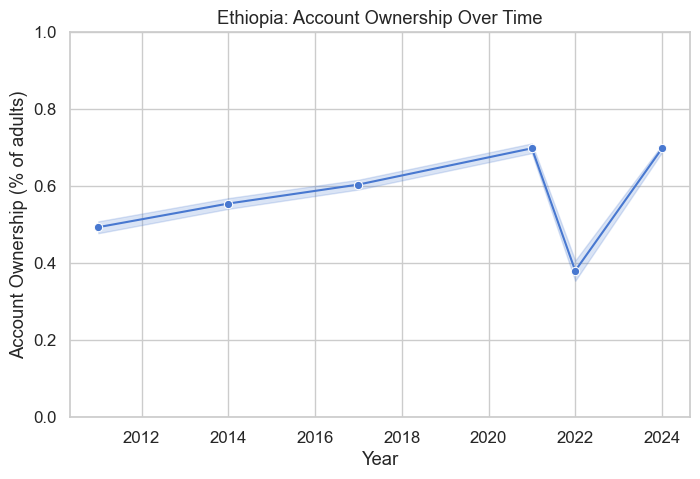

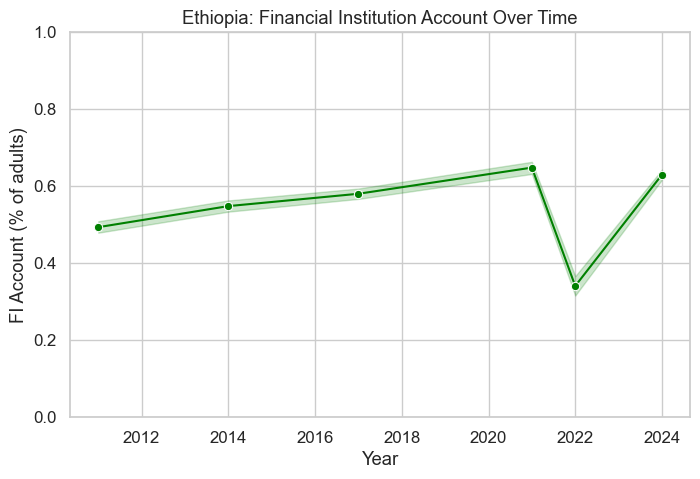

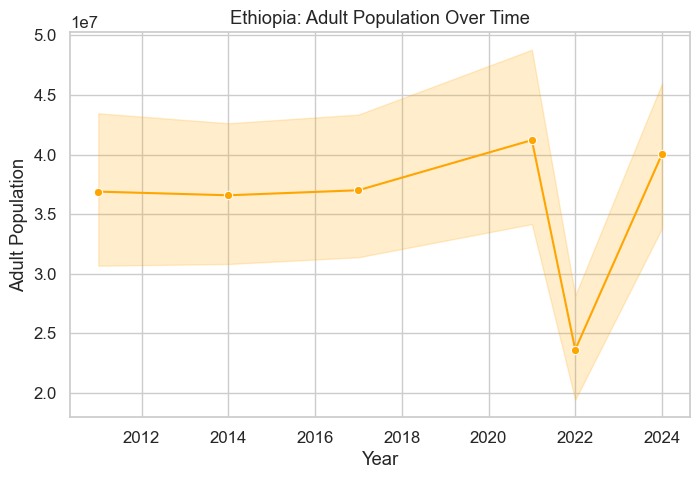

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the filtered Ethiopia data
eth_df = pd.read_csv("../data/raw/ethiopia_findex_filtered.csv")

# Ensure 'year' is integer
eth_df['year'] = eth_df['year'].astype(int)

# Set plot style
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

# 1️⃣ Account Ownership Over Time
plt.figure(figsize=(8,5))
sns.lineplot(data=eth_df, x='year', y='account_t_d', marker='o')
plt.title("Ethiopia: Account Ownership Over Time")
plt.ylabel("Account Ownership (% of adults)")
plt.xlabel("Year")
plt.ylim(0,1)
plt.show()

# 2️⃣ Financial Institution Account Over Time
plt.figure(figsize=(8,5))
sns.lineplot(data=eth_df, x='year', y='fiaccount_t_d', marker='o', color='green')
plt.title("Ethiopia: Financial Institution Account Over Time")
plt.ylabel("FI Account (% of adults)")
plt.xlabel("Year")
plt.ylim(0,1)
plt.show()

# 3️⃣ Adult Population Trend
plt.figure(figsize=(8,5))
sns.lineplot(data=eth_df, x='year', y='pop_adult', marker='o', color='orange')
plt.title("Ethiopia: Adult Population Over Time")
plt.ylabel("Adult Population")
plt.xlabel("Year")
plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_30556\2906698601.py:9: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  eth_df = pd.read_csv("../data/raw/GlobalFindexDatabase2025.csv")


Initial Ethiopia data shape: (8564, 437)
Columns preview: ['countrynewwb', 'codewb', 'year', 'pop_adult', 'regionwb24_hi', 'incomegroupwb24', 'group', 'group2', 'account_t_d', 'fiaccount_t_d', 'mobileaccount_t_d', 'borrow_any_t_d', 'fin4_d', 'dig_acc', 'fin11_2a']

Missing values per column:
Year                      0
Adult_Population        684
Account_Overall          90
FI_Account_Overall      182
MobileMoney_Overall    6050
Gender                    0
Group                     0
dtype: int64


<Figure size 1200x600 with 0 Axes>

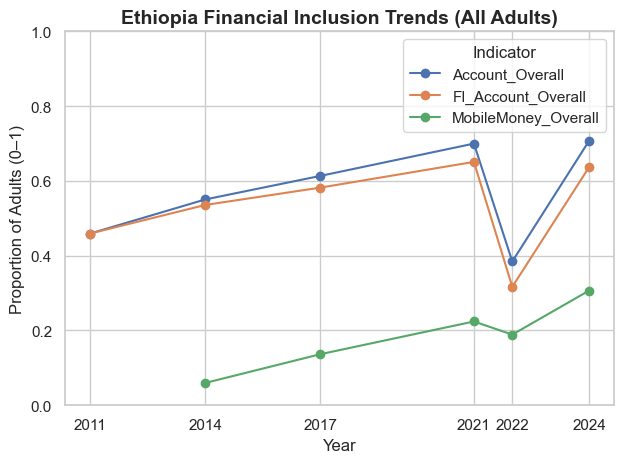

In [14]:
# 📌 Ethiopia Financial Inclusion - Baseline Trend Analysis
# Notebook: Clean, Explore, and Visualize Ethiopia Findex Data

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Load Ethiopia dataset
eth_df = pd.read_csv("../data/raw/GlobalFindexDatabase2025.csv")

print("Initial Ethiopia data shape:", eth_df.shape)
print("Columns preview:", eth_df.columns.tolist()[:15])

# 2️⃣ Select & rename key columns for clarity
columns_map = {
    "year": "Year",
    "pop_adult": "Adult_Population",
    "account_t_d": "Account_Overall",
    "fiaccount_t_d": "FI_Account_Overall",
    "mobileaccount_t_d": "MobileMoney_Overall",
    "group2": "Gender",
    "group": "Group"
}

eth_df = eth_df[list(columns_map.keys())].rename(columns=columns_map)

# 3️⃣ Convert numeric columns to float
numeric_cols = ["Adult_Population", "Account_Overall", "FI_Account_Overall", "MobileMoney_Overall"]
eth_df[numeric_cols] = eth_df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# 4️⃣ Quick check for missing values
print("\nMissing values per column:")
print(eth_df.isna().sum())

# 5️⃣ Plot baseline trends
sns.set(style="whitegrid")
plt.figure(figsize=(12,6))

# Aggregate by Year for overall trends
eth_agg = eth_df[eth_df['Gender']=='all'].groupby('Year')[["Account_Overall","FI_Account_Overall","MobileMoney_Overall"]].mean()

eth_agg.plot(marker='o')
plt.title("Ethiopia Financial Inclusion Trends (All Adults)", fontsize=14, fontweight='bold')
plt.ylabel("Proportion of Adults (0–1)")
plt.xlabel("Year")
plt.xticks(eth_agg.index)
plt.ylim(0,1)
plt.grid(True)
plt.legend(title="Indicator")
plt.tight_layout()
plt.show()


In [16]:
import pandas as pd

# 1️⃣ Load raw Ethiopia Findex data
eth_df = pd.read_csv("../data/raw/GlobalFindexDatabase2025.csv", low_memory=False)

# 2️⃣ Rename key columns for clarity
columns_map = {
    "year": "Year",
    "pop_adult": "Adult_Population",
    "account_t_d": "Account_Overall",
    "fiaccount_t_d": "FI_Account_Overall",
    "mobileaccount_t_d": "MobileMoney_Overall",
    "group2": "Gender",
    "group": "Group"
}
eth_df = eth_df[list(columns_map.keys())].rename(columns=columns_map)

# 3️⃣ Convert numeric columns
numeric_cols = ["Adult_Population", "Account_Overall", "FI_Account_Overall", "MobileMoney_Overall"]
eth_df[numeric_cols] = eth_df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# 4️⃣ Interpolate missing numeric values by Group + Gender
for col in numeric_cols:
    eth_df[col] = eth_df.groupby(['Group','Gender'])[col].transform(lambda x: x.interpolate(method='linear'))

# 5️⃣ Check missing values after interpolation
print("\nMissing values after interpolation:")
print(eth_df.isna().sum())

# 6️⃣ Save cleaned data
eth_df.to_csv("../data/processed/ethiopia_findex_clean.csv", index=False)
print("✅ Cleaned Ethiopia data saved at ../data/processed/ethiopia_findex_clean.csv")


Missing values after interpolation:
Year                      0
Adult_Population          0
Account_Overall           0
FI_Account_Overall        0
MobileMoney_Overall    1568
Gender                    0
Group                     0
dtype: int64
✅ Cleaned Ethiopia data saved at ../data/processed/ethiopia_findex_clean.csv


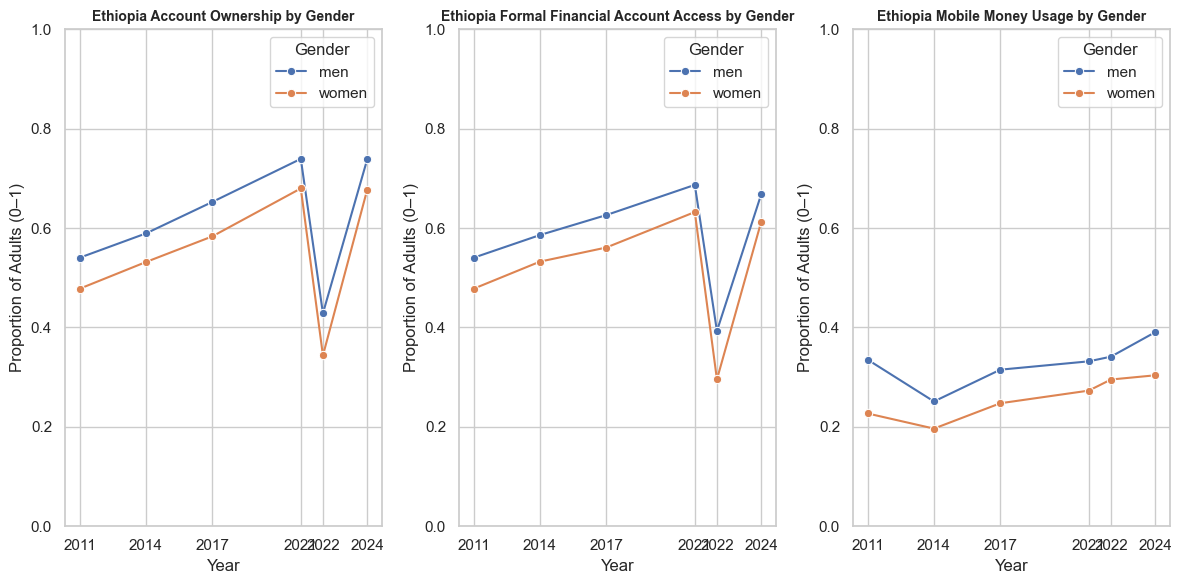

In [17]:
# 📌 Ethiopia Financial Inclusion - Gender-Disaggregated Trends

# Filter out the gender-specific rows (exclude 'all')
eth_gender_df = eth_df[eth_df['Gender'].isin(['men','women'])]

# Aggregate by Year and Gender
eth_gender_agg = eth_gender_df.groupby(['Year','Gender'])[
    ["Account_Overall","FI_Account_Overall","MobileMoney_Overall"]
].mean().reset_index()

# Plot gender-disaggregated trends
sns.set(style="whitegrid")
plt.figure(figsize=(12,6))

# Plot each indicator separately
indicators = ["Account_Overall","FI_Account_Overall","MobileMoney_Overall"]
titles = ["Account Ownership", "Formal Financial Account Access", "Mobile Money Usage"]

for i, ind in enumerate(indicators):
    plt.subplot(1,3,i+1)
    sns.lineplot(data=eth_gender_agg, x="Year", y=ind, hue="Gender", marker='o')
    plt.title(f"Ethiopia {titles[i]} by Gender", fontsize=10, fontweight='bold')
    plt.xlabel("Year")
    plt.ylabel("Proportion of Adults (0–1)")
    plt.ylim(0,1)
    plt.xticks(eth_gender_agg['Year'].unique())
    plt.legend(title="Gender")
    plt.grid(True)

plt.tight_layout()
plt.show()


   Year Group  Account_Overall  FI_Account_Overall  MobileMoney_Overall
0  2011   all         0.090050            0.090050                  NaN
1  2011   all         0.282681            0.282681                  NaN
2  2011   all         0.332861            0.332861                  NaN
3  2011   all         0.392035            0.392035                  NaN
4  2011   all         0.331302            0.331302                  NaN
Regional data shape: (8564, 5)


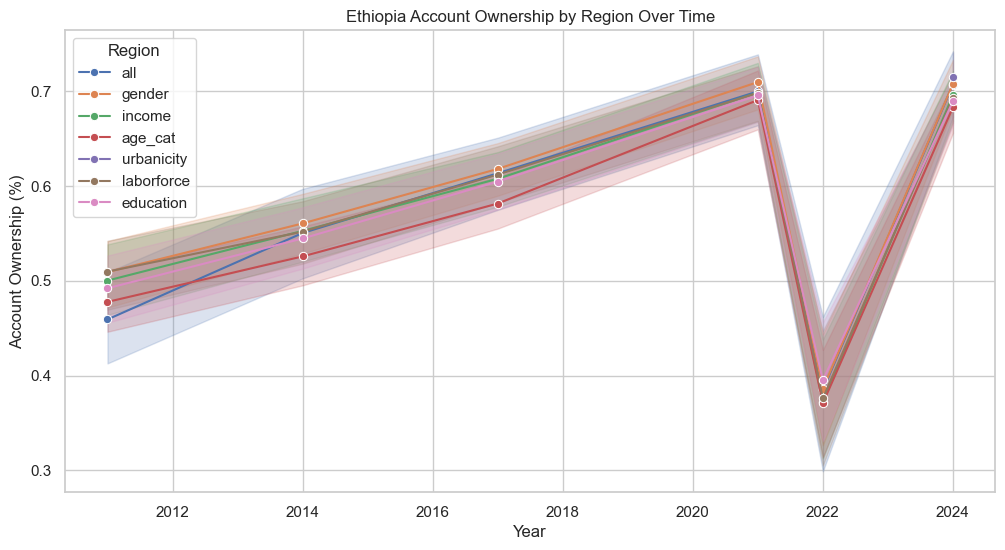

In [18]:
# 📌 Filter regional data (exclude national-level 'All' if present)
eth_region_df = eth_df[eth_df['Group'] != 'All']

# Select only relevant columns for analysis
region_cols = ['Year', 'Group', 'Account_Overall', 'FI_Account_Overall', 'MobileMoney_Overall']
eth_region_df = eth_region_df[region_cols]

# Quick look at the data
print(eth_region_df.head())
print("Regional data shape:", eth_region_df.shape)

# Example: plot regional Account Ownership trend over time
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.lineplot(data=eth_region_df, x='Year', y='Account_Overall', hue='Group', marker='o')
plt.title("Ethiopia Account Ownership by Region Over Time")
plt.ylabel("Account Ownership (%)")
plt.xlabel("Year")
plt.legend(title="Region")
plt.show()